In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from util.augmentation import *
from model import MR_Transformer
import timm
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [2]:
class MRI_dataset(Dataset):
    def __init__(self,
                 data_df_path,
                 mri_path = '/gpfs/data/denizlab/Datasets/OAI/COR_IW_TSE/00m/',
                 train = True):
        
        self.data_df = pd.read_csv(data_df_path)
        self.mri_path = mri_path
        self.train = train
        self.label_index = 'Label'
        self.image_path_index = 'FileName'
        self.t2map_images = False
        self.tse_images = True
        self.image_size = [36, 384, 384]
        self.num_MR_slices = 36
        self.channels =  3
        self.aug_RandomRescale =  True
        self.aug_resize_scale = (0.9,1.3)
        self.aug_degrees = 10
        self.aug_RandomFlip = True
        self.aug_GaussianBlur = True
        
        
    def __getitem__(self, index):

        image_path = os.path.join(self.mri_path,self.data_df.iloc[index][self.image_path_index])
        
        if self.t2map_images:
            image = read_t2mapping_hdf5(image_path, self.num_MR_slices)
        elif self.tse_images:
            image = read_iw_tse_hdf5(image_path, self.num_MR_slices)
            
        if self.train:
            if self.aug_RandomRescale:
                image = RandomRescale2D(self.aug_resize_scale)(image)
            image = SimpleRotate(self.aug_degrees)(image)
            image = RandomCrop(self.image_size)(image)
            image = Standardize()(image)
            if self.aug_RandomFlip:
                image = RandomFlip()(image)
            if self.aug_GaussianBlur:
                image = GaussianBlur()(image)  
            image = ToTensor()(image)
            image = RepeatChannels(self.channels)(image)
            
        else: 
            image = CenterCrop(self.image_size)(image)
            image = Standardize()(image)
            image = ToTensor()(image)
            image = RepeatChannels(self.channels)(image)
            
        label = self.data_df.iloc[index][self.label_index]
        label = torch.tensor(label, dtype=torch.long)

        return image.float(), label, index
    
    def __len__(self):
        return len(self.data_df)

In [3]:
test_csv = 'Data/Nested_Cross_Validation/OAI_COR_IW_TSE/NCV_7/OAI_TKR_7fold_COR_IW_TSE_NCV7_test.csv'
mri_dataset = MRI_dataset(data_df_path=test_csv, train=False)

In [4]:
sample = mri_dataset.__getitem__(85)[0]
sample = sample.unsqueeze(0)

In [5]:
model = MR_Transformer(mr_slice_size=384)
model.to(device);
model.load_state_dict(torch.load('../NCV7_CV1.pt',map_location=torch.device('cpu'))['best_model_wts'])
for name, module in model.named_modules():
    if isinstance(module, timm.models.vision_transformer.Attention):
        module.fused_attn = False
model.eval();

Using cache found in /gpfs/home/cz2064/.cache/torch/hub/facebookresearch_deit_main


In [6]:
class Attention_Hook:
    def __init__(self, model, attention_layer_name='attn_drop'):
        self.model = model
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)
        return self.attentions

def array_to_uint8(array):
    array = (array - np.min(array))
    array = array/(np.max(array) + 1e-10)
    image = np.uint8(255 * array)
    return image


def plot_slices(sample_array):
    cases = list(range(sample_array.shape[0]))
    figsize = (20, 20)
    cols = 6
    rows = int(np.ceil(len(cases)/6))
    def trim_axs(axs, N):
        axs = axs.flat
        for ax in axs[N:]:
            ax.remove()
        return axs[:N]
    axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
    axs = trim_axs(axs, len(cases))
    for ax, case in zip(axs, cases):
        ax.imshow(sample_array[case],cmap='gray');
        ax.set_axis_off();
    return axs;

In [7]:
rollout = Attention_Hook(model)
all_attn = rollout(sample.to(device))
print(len(all_attn))
print(all_attn[0].shape)

12
torch.Size([1, 3, 20737, 20737])


In [8]:
discard_ratio = 0
result = torch.eye(all_attn[0].size(-1))
for attention in all_attn:
    attention_heads_fused = attention.mean(axis=1).detach().cpu()
    flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
    _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
    indices = indices[indices != 0]
    flat[0, indices] = 0

    I = torch.eye(attention_heads_fused.size(-1))
    a = (attention_heads_fused + 1.0*I)/2
    a = a / a.sum(dim=-1)

    result = torch.matmul(a, result)
mask = result[0, 0 , 1 :].numpy()

In [9]:
w_patch_num = sample.size(-1)//16
mask_reshape = np.reshape(mask,(36,w_patch_num*w_patch_num))
mask_reshape = np.reshape(mask_reshape,(36,w_patch_num,w_patch_num))

mri_w = sample.size(-1)
resized_heatmap = np.transpose(mask_reshape, (1, 2, 0))
resized_heatmap = cv2.resize(resized_heatmap, (mri_w, mri_w))
resized_heatmap = np.transpose(resized_heatmap, (2,0,1))
resized_heatmap = array_to_uint8(resized_heatmap)

color_heatmap = np.zeros((36, mri_w, mri_w, 3))
for i in range(36):
    color_heatmap[i] = cv2.cvtColor(cv2.applyColorMap(resized_heatmap[i], cv2.COLORMAP_HOT), cv2.COLOR_BGR2RGB)

sample_array = sample[0][0].numpy()
knee_sample = np.zeros([36,mri_w,mri_w,3])
for i in range(36):
    knee_sample[i] = cv2.cvtColor(array_to_uint8(sample_array[i]), cv2.COLOR_GRAY2RGB)
knee_sample = knee_sample.astype(np.uint8)
visualization = np.uint8(color_heatmap * 0.4 + knee_sample * 0.6)

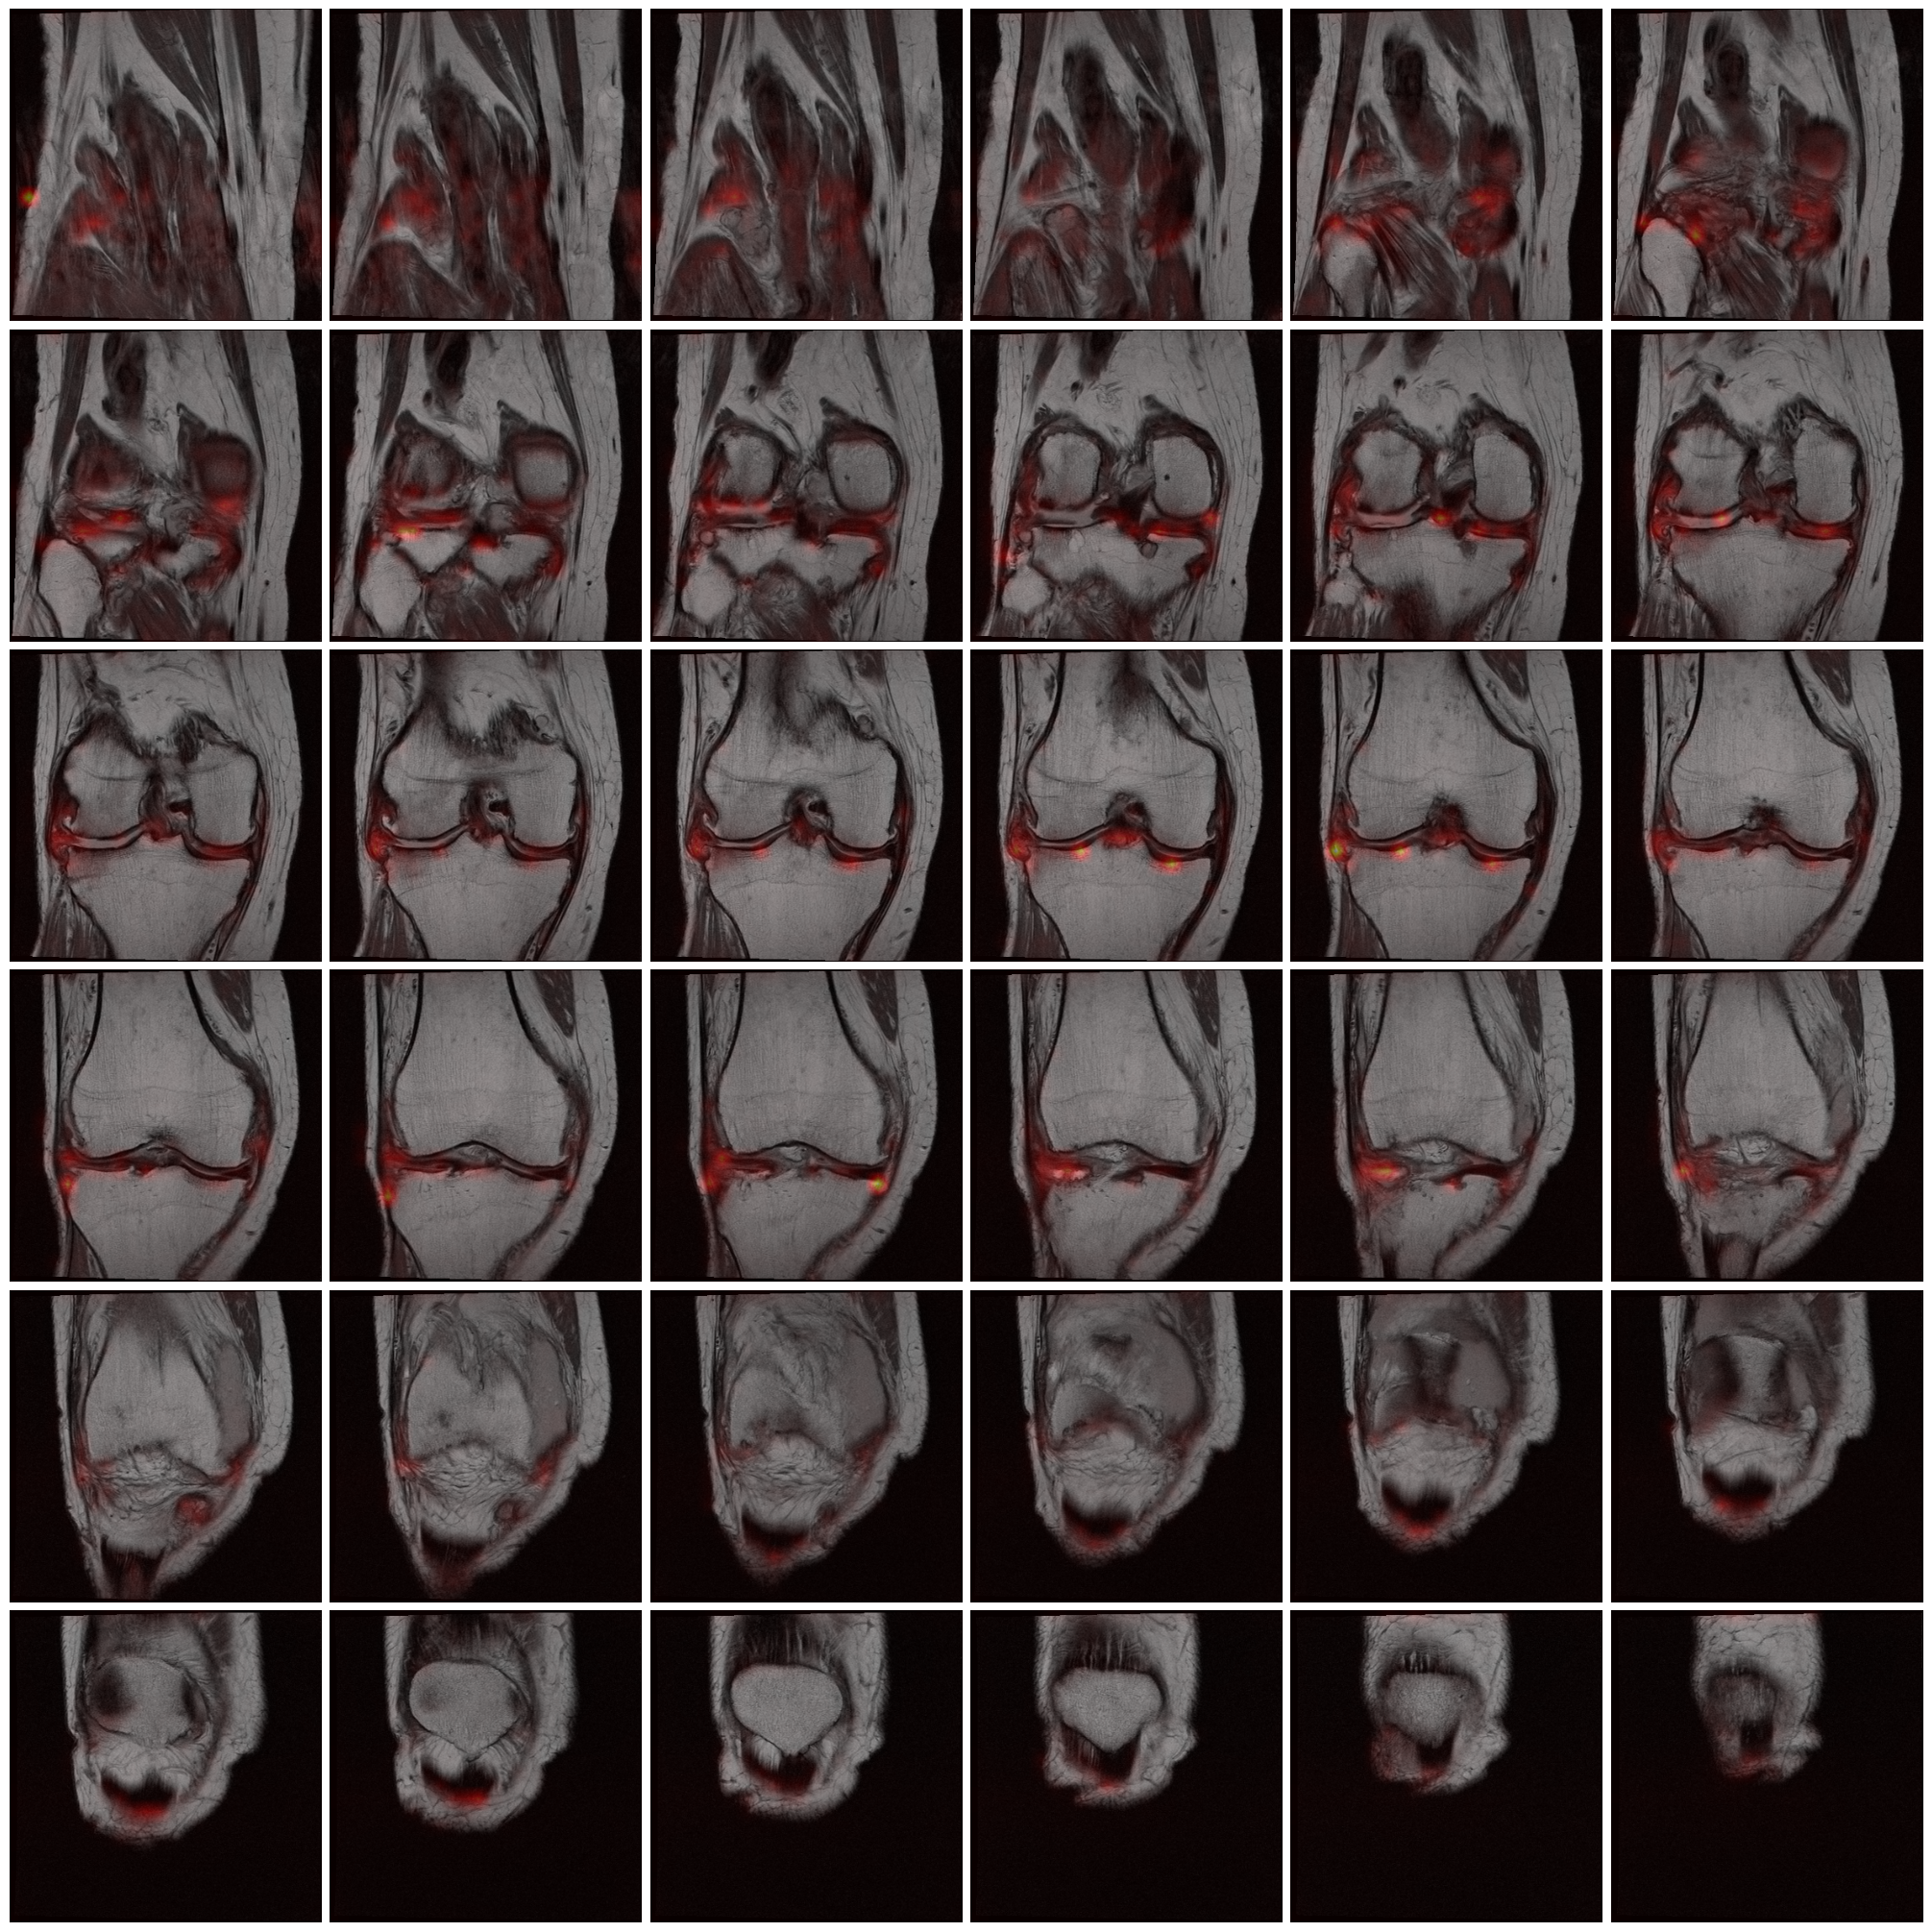

In [10]:
plot_slices(visualization);